In [1]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)
    
    # TO CHECK: WHY N-1?!?!? isn't range enough to stop at N-1?!
    # _s stands for _structure below: 
    for i in range(N-1):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    

In [3]:
def LouvainCorrelationClustering(R):   # R is a matrix of return
    
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
      
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)
    DF=pd.DataFrame.from_dict(partition,orient="index")
    DF['StockName'] = R.columns
    DF = DF.reset_index()
    DF = DF.drop(columns = 'index')
    DF = DF.rename({0: 'Cluster'},axis = 'columns')
    DF = DF.set_index('StockName')
    return(DF)

In [4]:
# clust_louvain=LouvainCorrelationClustering(DF_cut)
# print(clust_louvain)
# print(clust_louvain.value_counts()) # 6 clusters

In [5]:
import numpy as np

DF=pd.read_parquet("us_equities_logreturns.parquet")

DF_cut=DF
display(DF)

sel=DF_cut.isnull().sum(axis=0)>0
DF_cut=DF_cut.drop(columns=DF_cut.columns[sel])
display(DF_cut)

,^GSPC,GE,IBM,DIS,BA,CAT,AA,HPQ,DD,KO,...,NSM,CLP,CTX,CTR,DYN,AIB,KIM,SFN,TCO,S
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.011340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.004737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.002949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16150,0.000305,-0.005420,-0.002896,0.004063,-0.009916,-0.000207,-0.001642,-0.010756,0.006343,-0.000520,...,0.042972,NaN,0.001974,-0.001879,0.011547,0.003892,0.002334,0.011191,0.009188,0.000000
16151,-0.011770,-0.016439,-0.012537,-0.017978,-0.020624,-0.012576,-0.025803,-0.023249,-0.010898,-0.013082,...,-0.011131,NaN,0.007076,-0.006604,-0.008647,-0.001296,0.001863,0.001534,-0.000436,-0.018391
16152,-0.002826,-0.009118,-0.009232,0.001750,0.009959,-0.002304,-0.001688,0.005519,0.000913,0.005253,...,0.047769,NaN,0.007026,0.003307,0.008237,0.003020,0.001395,0.005350,-0.015368,0.018391
16153,0.009568,0.012663,0.019565,0.016351,0.018590,0.002931,0.005055,0.014005,0.009232,0.002616,...,-0.017531,NaN,0.003882,0.007987,0.002458,0.025942,0.000465,0.009860,0.000442,-0.001140


""
0
1
2
3
4
...
16150
16151
16152
16153


Index(['^GSPC', 'GE', 'IBM', 'DIS', 'BA', 'CAT', 'AA', 'HPQ', 'DD', 'KO',
       ...
       'NSM', 'CLP', 'CTX', 'CTR', 'DYN', 'AIB', 'KIM', 'SFN', 'TCO', 'S'],
      dtype='object', length=1012)


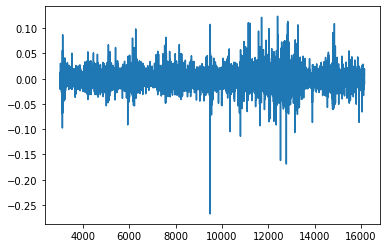

In [6]:
import matplotlib.pyplot as plt
print(DF.columns)
plt.plot(DF['IBM'].index, DF['IBM'])
#The returns are daily because 16k/252 is around 60 years

## Louvain clustering

In [96]:
clust_louvain=LouvainCorrelationClustering(DF_cut)
#print(clust_louvain)
#print(clust_louvain.value_counts()) # 6 clusters

def drop_nans(df,limit = 0.5):
    """given a dataframe and a limit value, first drops all the columns that have
    more than limit % nans than drops all raws containing at least one nan value"""
    row_num = df.shape[0]
    nan_col = df.isnull().sum(axis=0)>(row_num*limit)
    df=df.drop(columns=df.columns[nan_col])
    return df.dropna()

def pick_n_from_k(df,n,seed = 0,onlynames = False):
    """given a dataframe and a number N, returns a dataframe that 
    contains n randomly selected columns of the input dataframe"""
    
    k = df.shape[0]
    
    #safety check
    assert k >= n, 'K should be >= N'
    
    #if onlynames is active return only the name of the columns
    if onlynames:
        random.seed(seed)
        return random.sample(list(df.columns), n)
    return df.sample(n=n, random_state=seed, axis='columns')

def bootstrap_CI(data, nbr_draws):
    """Given an array and a number of random samples performs bootstrapping to
    find the confidence intervals of the mean"""
    # Input: your array and the number of random samples (e.g., 1000 is a good number)
    # Output: [lower error, upper error]

    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 0.5),np.nanpercentile(means, 99.5)]

def optimalWeights(df,verbose = False,shortBan = True):
    """use pypfopt to compute the optimal weights of the portfolio following markovitz strategy"""
    mu = expected_returns.mean_historical_return(df,returns_data=True,log_returns =True)
    S = risk_models.sample_cov(df,returns_data=True,log_returns =True)
    if shortBan:
        #By default the ef is long only 
        ef = EfficientFrontier(mu, S)
    else:
        #Allow negative weights => No shortBan
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    #We could limit the maxweight just by changing the bounds ex: max 10% with shortban weight_bounds=(0, 0.1)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if verbose:
        return ef.portfolio_performance(verbose=False)
    return cleaned_weights

def weight_inverse_std(df):
    sum_stds = 0
    cluster = df['Cluster'].iloc[0]
    df = df.drop(columns = ['Cluster']).transpose()
    for col in df.columns:
        if col != 'Cluster':
            sum_stds += df[col].std()
    for col in df.columns:
        if col != 'Cluster':
            df[col] = df[col]*df[col].std()/sum_stds
    df = df.mean(axis = 1)
    df = df.transpose()
    df['Cluster'] = cluster
    #df = df.transpose()
    return df

def compute_clusters_returns(df,clusters,strategy = 'equal weight'):
    """given a dataframe and his clusters compute the clusters means"""
    
    if strategy == 'equal weight':
        means = df.transpose()
        means = pd.merge(means, clusters,left_index = True, right_on='StockName')
        means = means.groupby('Cluster').mean().transpose()
    elif strategy == 'inverse std':
        #TO DO: test this method
        dftr = df.transpose()
        dftr = pd.merge(dftr, clusters,left_index = True, right_on='StockName')
        means = dftr.groupby('Cluster').apply(lambda x: weight_inverse_std(x))
        means = means.drop(columns = ['Cluster']).transpose()
    return means

def compute_portfolio_return(df,clustering = 'louvian',strategy ='equal weight'):
    """given a dataframe, a clustering method and a portfolio weighting strategy
    compute the return of the portfolio composed by appling clustering than combining
    the clusters using the strategy"""
    if strategy == 'equal weight':
        
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            cluster_means = compute_clusters_returns(df,clusters)
            portfolio_mean = cluster_means.mean().mean()
            portfolio_std = cluster_means.mean(axis = 1).std()
            portfolio_std = np.exp((portfolio_std)*252)-1
            portfolio_mean = np.exp((portfolio_mean)*252)-1
            SharpR = portfolio_mean/portfolio_std
            return portfolio_mean,portfolio_std,SharpR
        
    elif strategy == 'inverse std':
        
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            cluster_means = compute_clusters_returns(df,clusters)
            cluster_std = cluster_means.std()
            weights = np.array([ i/sum(list(cluster_std)) for i in list(cluster_std)]).T
            # I dont know if I can do the mean before or not maybe it changes if variables are dependent
            portfolio_mean = (np.array(cluster_means)@weights).mean()
            portfolio_std = (np.array(cluster_means)@weights).std()
            portfolio_std = np.exp((portfolio_std)*252)-1
            portfolio_mean = np.exp((portfolio_mean)*252)-1
            SharpR = portfolio_mean/portfolio_std
            return portfolio_mean,portfolio_std,SharpR
        
    elif strategy == 'markovitz':
        
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            cluster_means = compute_clusters_returns(df,clusters)
            portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
            return portfolio_mean,portfolio_std,SharpR
        
        #no clustering only markovitz portfolio
        elif clustering == 'NO clustering':
            portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
            return portfolio_mean,portfolio_std,SharpR       
            
def compute_stategy_avg_return(df,n,n_picks,clustering = 'louvian',strategy ='equal weight'):
    """given a dataframe, a number of picks, a size n, a clustering method and a portfolio weighting strategy
    compute the average return of n_picks portfolios composed picking at random n stocks from the df,
    applying clustering and combining with the weight strategy"""
    portfolio_returns = []
    portfolio_risks = []
    portfolio_sharpRs = []
    for i in range(n_picks):
        sub_df = pick_n_from_k(df,n,seed = (i+1))
#         print(list(sub_df.columns))
        portfolio_return,portfolio_risk,SharpR = compute_portfolio_return(sub_df,clustering = clustering,strategy = strategy)
        print('portfolio nb: ',i, 'return: ',portfolio_return)
        portfolio_returns.append(portfolio_return)
        portfolio_risks.append(portfolio_risk)
        portfolio_sharpRs.append(SharpR)
    portfolio_returns_mean = sum(portfolio_returns)/len(portfolio_returns)
    CI = bootstrap_CI(portfolio_returns,int(n_picks/1.5))
    yerr = [-(CI[0]-portfolio_returns_mean),CI[1]-portfolio_returns_mean]
#     print(portfolio_returns_mean)
    plt.errorbar(1,portfolio_returns_mean,yerr = np.array(yerr).reshape(2,1), fmt='.', ecolor = 'red')
    plt.ylabel("Mean return of clustering method :" + clustering +' ' + strategy)
    plt.title("Mean return of clustering method with confidence intervals")
    return portfolio_returns,portfolio_risks,portfolio_sharpRs

In [97]:
DF=pd.read_parquet("us_equities_logreturns.parquet")

DF = drop_nans(DF)
#display(DF)

portfolio nb:  0 return:  0.12637960062385645
portfolio nb:  1 return:  0.11914580532428087
portfolio nb:  2 return:  0.14156995182531262
portfolio nb:  3 return:  0.13538660731143448
portfolio nb:  4 return:  0.13415715947271334
portfolio nb:  5 return:  0.134883335237447
portfolio nb:  6 return:  0.1353595711686839
portfolio nb:  7 return:  0.13231161538231873
portfolio nb:  8 return:  0.13302407019377505
portfolio nb:  9 return:  0.1308447821469192
strategy mean:  ([0.12637960062385645, 0.11914580532428087, 0.14156995182531262, 0.13538660731143448, 0.13415715947271334, 0.134883335237447, 0.1353595711686839, 0.13231161538231873, 0.13302407019377505, 0.1308447821469192], [14.722878754348997, 16.27426582462073, 14.359912732167588, 13.632121163894226, 13.96431786688257, 13.566603102032147, 13.47657292068975, 14.809355446394035, 13.786830363900648, 14.682559919808913], [0.008583891963827056, 0.007321117069627167, 0.009858691655429234, 0.009931441019613062, 0.009607140194858864, 0.0099423

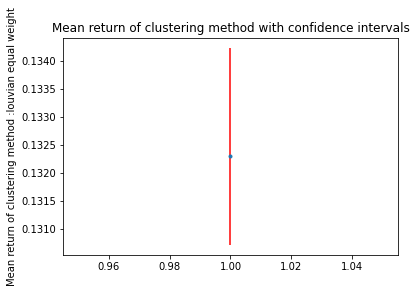

In [98]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10))

portfolio nb:  0 return:  0.12397978143036648
portfolio nb:  1 return:  0.11998681543493572
portfolio nb:  2 return:  0.14082328089426777
portfolio nb:  3 return:  0.13221565717787698
portfolio nb:  4 return:  0.12893337413805273
portfolio nb:  5 return:  0.1332924016710011
portfolio nb:  6 return:  0.13541789768726176
portfolio nb:  7 return:  0.13094714413053676
portfolio nb:  8 return:  0.1305287263019217
portfolio nb:  9 return:  0.12824116504044758
strategy inv std:  ([0.12397978143036648, 0.11998681543493572, 0.14082328089426777, 0.13221565717787698, 0.12893337413805273, 0.1332924016710011, 0.13541789768726176, 0.13094714413053676, 0.1305287263019217, 0.12824116504044758], [15.53472006332034, 16.06150485228736, 14.449344698966193, 14.250656009626669, 14.807681894869846, 13.822093808289914, 13.567805215037996, 14.996496857074366, 14.079490012499027, 15.135569710948484], [0.007980818510086975, 0.007470459121882847, 0.009745997747866258, 0.00927786461820158, 0.008707195025760377, 0.

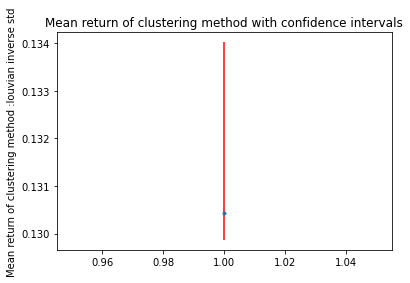

In [99]:
print('strategy inv std: ',compute_stategy_avg_return(DF,65,10,strategy = 'inverse std'))

portfolio nb:  0 return:  0.1524700176827279
portfolio nb:  1 return:  0.204080508460139
portfolio nb:  2 return:  0.19716021174467618
portfolio nb:  3 return:  0.20204718865647003
portfolio nb:  4 return:  0.19574706489851992
portfolio nb:  5 return:  0.17414663073154096
portfolio nb:  6 return:  0.1717986651094257
portfolio nb:  7 return:  0.19490158192475046
portfolio nb:  8 return:  0.19600623823939545
portfolio nb:  9 return:  0.17358232688575934
strategy mean:  ([0.1524700176827279, 0.204080508460139, 0.19716021174467618, 0.20204718865647003, 0.19574706489851992, 0.17414663073154096, 0.1717986651094257, 0.19490158192475046, 0.19600623823939545, 0.17358232688575934], [0.1698420117057522, 0.1904378220849692, 0.17400978313261703, 0.17868570945690182, 0.17183823881242027, 0.16630725002733815, 0.17228590017736348, 0.17613875128952955, 0.17383351464328708, 0.17408372899078015], [0.7799602486587918, 0.966617379072978, 1.0181048936177235, 1.018812244190009, 1.0227471260943646, 0.92687859

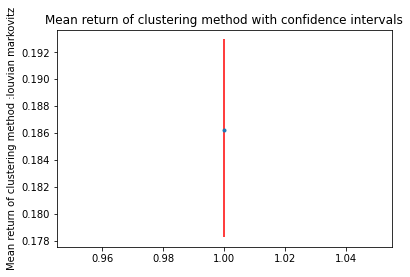

In [100]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,strategy = 'markovitz'))

portfolio nb:  0 return:  0.1524700176827279
portfolio nb:  1 return:  0.204080508460139
portfolio nb:  2 return:  0.19716021174467618
portfolio nb:  3 return:  0.20204718865647003
portfolio nb:  4 return:  0.19574706489851992
portfolio nb:  5 return:  0.17414663073154096
portfolio nb:  6 return:  0.1717986651094257
portfolio nb:  7 return:  0.19490158192475046
portfolio nb:  8 return:  0.19600623823939545
portfolio nb:  9 return:  0.17358232688575934
strategy mean:  ([0.1524700176827279, 0.204080508460139, 0.19716021174467618, 0.20204718865647003, 0.19574706489851992, 0.17414663073154096, 0.1717986651094257, 0.19490158192475046, 0.19600623823939545, 0.17358232688575934], [0.1698420117057522, 0.1904378220849692, 0.17400978313261703, 0.17868570945690182, 0.17183823881242027, 0.16630725002733815, 0.17228590017736348, 0.17613875128952955, 0.17383351464328708, 0.17408372899078015], [0.7799602486587918, 0.966617379072978, 1.0181048936177235, 1.018812244190009, 1.0227471260943646, 0.92687859

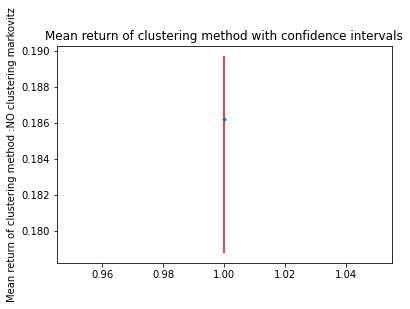

In [101]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,clustering = 'NO clustering',strategy = 'markovitz'))

## Maximum likelihood clustering



There is no code for this method in Python. The following shows how to call R from Python.

In [76]:
!pip install rpy2 -U

Requirement already up-to-date: rpy2 in c:\users\mauro\anaconda3\lib\site-packages (3.4.5)


In [77]:
# first install R https://cran.rstudio.com/
# # run this cell the first time you use rpy2 only.

from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages("data.table")
 

--- Per piacere, seleziona un mirror CRAN per la sessione ---


From cffi callback <function _consolewrite_ex at 0x00000183501BB828>:
Traceback (most recent call last):
  File "C:\Users\mauro\Anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\mauro\Anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 78: invalid continuation byte
R[write to console]: trying URL 'https://stat.ethz.ch/CRAN/bin/windows/contrib/4.1/data.table_1.14.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2600662 bytes (2.5 MB)

R[write to console]: downloaded 2.5 MB




package 'data.table' successfully unpacked and MD5 sums checked


R[write to console]: Warning:
R[write to console]:  cannot remove prior installation of package 'data.table'

R[write to console]: Warning:
R[write to console]:  restored 'data.table'




The downloaded binary packages are in
	C:\Users\mauro\AppData\Local\Temp\RtmpIDP8UX\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x00000183502A1F08> [RTYPES.NILSXP]

In [78]:
import rpy2.robjects as robjects
r = robjects.r

#importr("data.table")
newfunc = r.source("""libClusteringGiadaMarsiliFast.R""")
aggregateClusters=robjects.globalenv["aggregateClusters"]   # now aggregateClusters is a Python function


R[write to console]: Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In file.copy(savedcopy, lib, recursive = TRUE) :
R[write to console]: 
 
R[write to console]:  problem copying C:\Users\mauro\Documents\R\win-library\4.1\00LOCK\data.table\libs\x64\datatable.dll to C:\Users\mauro\Documents\R\win-library\4.1\data.table\libs\x64\datatable.dll: Permission denied

R[write to console]: 2: 
R[write to console]: In file(filename, "r", encoding = encoding) :
R[write to console]: 
 
R[write to console]:  cannot open file 'libClusteringGiadaMarsiliFast.R': No such file or directory



RRuntimeError: Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection


In [28]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

C=DF_cut.corr()


In [31]:
clust_ML=aggregateClusters(C.values)

NameError: name 'aggregateClusters' is not defined

In [ ]:
clust_ML[3]   # this is a dictionary (List in the R language) which contains the membership of each cluster, one cluster at a time

In [ ]:
np.array(clust_ML[3][0]) # first cluster

In [ ]:
pd.DataFrame(np.array(clust_ML.rx["s_i"][0]).flatten()).value_counts() # 49 clusters, of highly heterogeneous size